# Creating sediment input into Landlab NetworkSedimentTransporter component

#### This tutorial was created by graduate students as part of the 2021 CSDMS ESPIn (Earth Surface Processes Institute).

# The NST-notebook

Unfortunately we could not run it without errors yet. It’s still in a development stage,
It still needs some work. We present here the overall modeling framework linking Landlab NetworkSedimentTransport (NST) component to Landlab SPACE component, and demonstrate how to add a random distribution os sediment in the NST model. 

#### Creators
Marius Huber - CNRS, Université de Lorraine

Mel Guirro - Durham University

Muneer Ahammad - VT

Se Jong Cho - USGS 

With help from Shelby Ahrendt - University of Washington


## Notebook Overview
This notebook is the second part of the 'Slope and Channels' group of 2021 CSDMS ESPIn.
The first part used Landlab SPACE component to evaluate how fire or landslide would increase sediment availability from hillslopes into channels. You can check the first part here: **ADD LINK TO SPACE TEAM JUPYTER NOTEBOOK**

This second part will synthetically introducte the increased sediment availability from fire or landslide at adjacent nodes and
use the Landlab NetworkSedimentTransporter (NST) component to run the sediment through the river network.

The goal is to couple existing landlab models with modifications to elements drving sediment transport.


### Modeling Objectives
1. Couple the river network from SPACE to NetworkSedimentTransporter, by creating the river network model grid from landscape grid created from SPACE.
2. Run the NetworkSedimentTransporter.
3. Compare the results from SPACE and NetworkSedimentTransporter, to analyse how each component represents sediment transport.

### Landlab Components used
Space

NetworkSedimentTransporter

## Conceptual Model


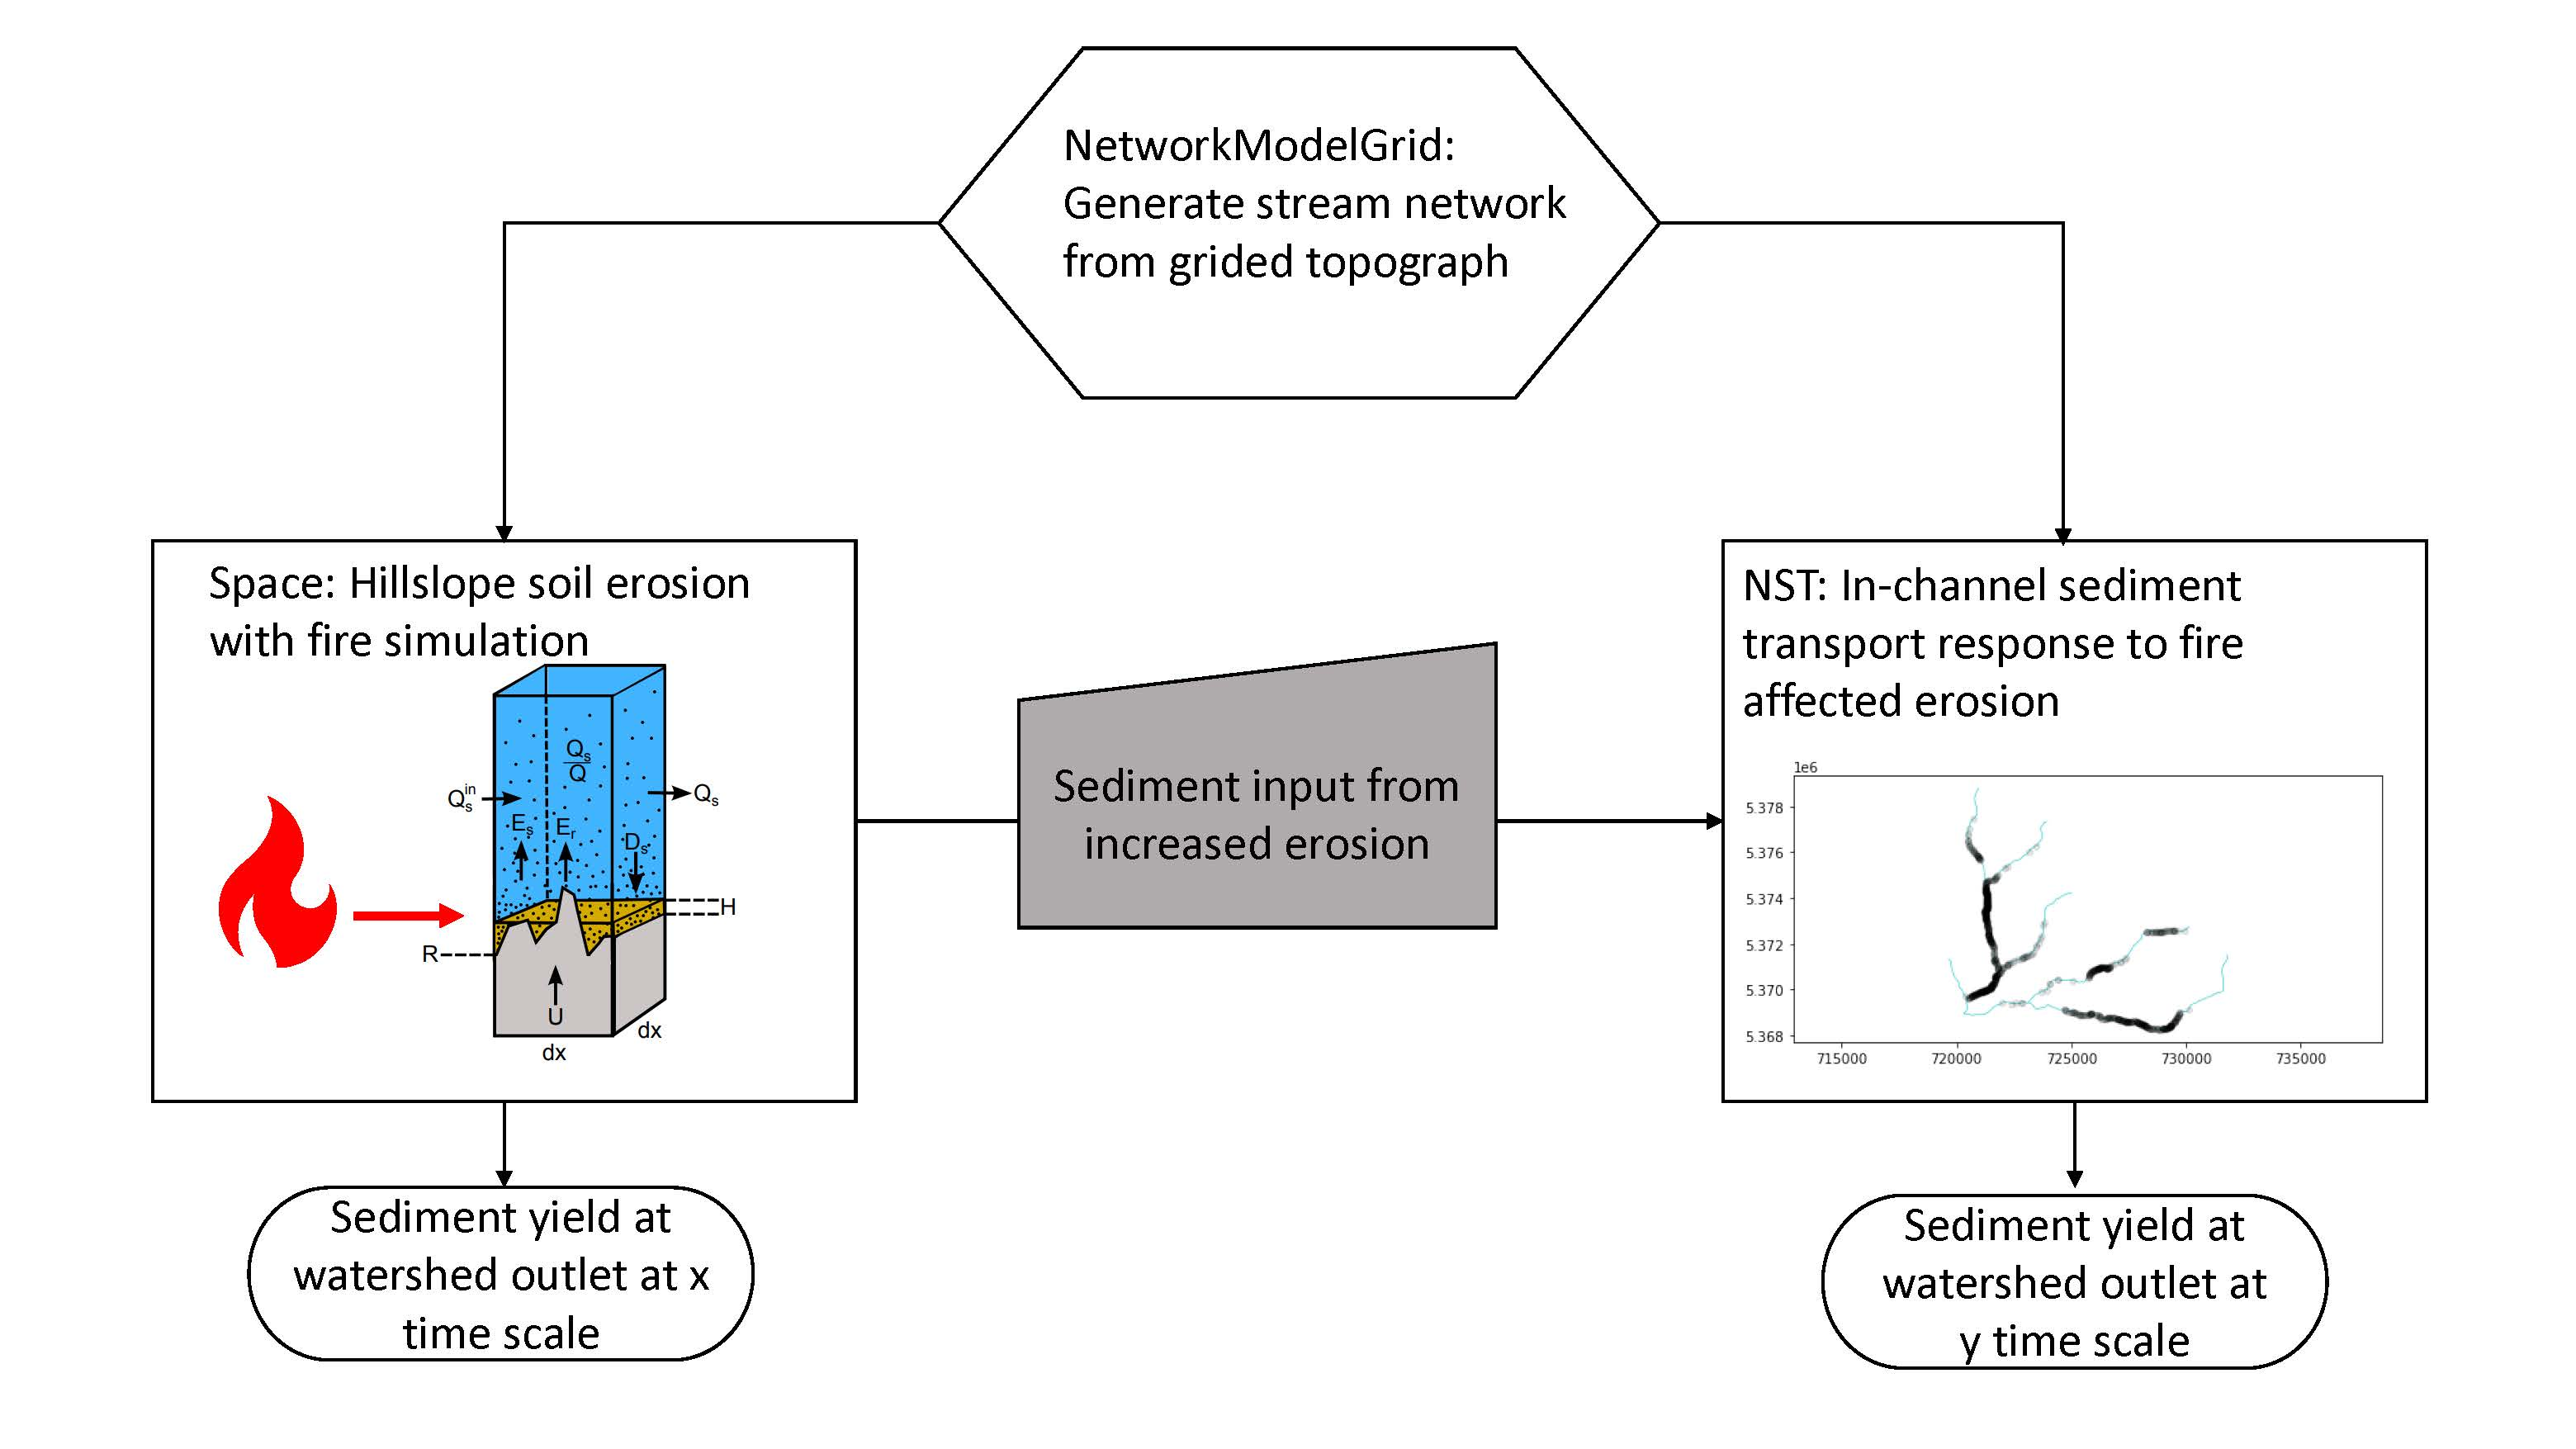

## Load the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node

from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid

from landlab.plot import graph
from landlab.plot import plot_network_and_parcels

from landlab.io import read_esri_ascii

# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

import landlab.plot.colors
from landlab import (RasterModelGrid,
                     imshow_grid)

%matplotlib inline

## 1. Create the river network model grid from landscape grid created from SPACE

Import the Digital Elevation Model (DEM) created from Space simulation and plot it.

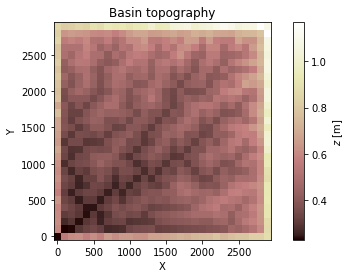

In [3]:
#Fetch DEM ascii

#slopeChannel_dir = os.path.dirname('/home/marius/Documents/Doctorat/ESPIn/slopes-channels/') #NEED TO ENTER CORRECT DIRECTORY!!!
#raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
#raster_fn = os.path.join(slopeChannel_dir, 'exampleDEM.asc') #windows
raster_fn = open('exampleDEM.asc', 'r') #I moved the file from the parent directory to /NST to access this file

#define landcape grid
mg, z = read_esri_ascii(raster_fn, name='exampleDEM')
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] =z
#rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
#rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

##topographic__elevation=z

#plot dem
plt.figure(figsize=(8,4))
imshow_grid(mg, 'exampleDEM',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

## 2. Create a Network Grid from Raster Grid
Extracts a NetworkModelGrid from the imported DEM or RasterModelGrid using the python model 'create_network_from_raster' in create_network.py.

Then plots the nodes, links, and node&link on DEM. This is the stream network/node for running NST.


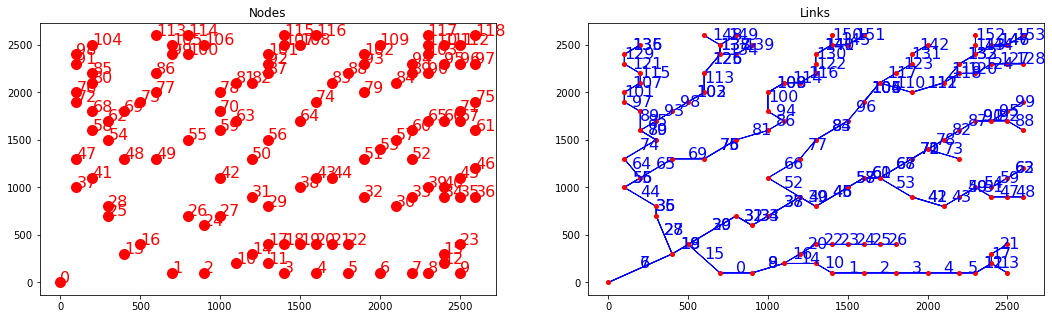

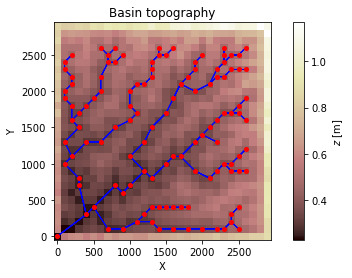

In [7]:
#create channel network grid from landscape grid from <Space team: minimalSpaceExample.ipynb>
from create_network import create_network_from_raster # Shelby's code to make a channel network from a grid

dx = 100 #grid spacing? Is this correct? needs to be checked

nmg = create_network_from_raster(
    mg,
    method='variable', 
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

# Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

# Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

#plot with topo
plt.figure(figsize=(8,4))
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg,with_id=False)
imshow_grid(mg, 'topographic__elevation',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

### Examine the variable outputs from running 'create_network_from_raster'to make sure all the elements are present for running NST.

Let's see what fields we read with new network shapefile we created from DEM output from SPACE

In [8]:
nmg.number_of_links

154

In [9]:
nmg.number_of_nodes

119

In [ ]:
nmg.at_link.keys()

Links are empty because NetworkModelGrid (NMG) created doesn't store information about links. Thus, we need to assign "reach_length", "drainage_area", "x_of_polyline", and "y_of_polyline" in the NMG.

In [ ]:
nmg.add_field("reach_length", nmg.length_of_link, at="link")

In [ ]:
#nmg.add_field("drainage_area", nmg.at_node['drainage_area'], at="link")

In [ ]:
#nmg.add_field("x_of_polyline", nmg.at_node['drainage_area'], at="link")

In [ ]:
#nmg.add_field("y_of_polyline", nmg.at_node['drainage_area'], at="link")

Now, let's check the fields populated for the links:

In [ ]:
nmg.at_link.keys()

Now, let's examine the fields in the nodes:

In [ ]:
nmg.at_node.keys()

Now we have populated all the fields needed for running NST.

### Next, populate the grid with relevant topographic and hydrologic information:

We must distinguish between topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment).

In [10]:
nmg.at_node["bedrock__elevation"] = nmg.at_node["topographic__elevation"].copy()

nmg.at_link["channel_width"] = 1 * np.ones(nmg.number_of_links) # m

nmg.at_link["flow_depth"] = 0.5 * np.ones(nmg.number_of_links) # m

### There are still problems with the network created from DEM. From here on we demonstrate NST modified by external sediment sources from fire/landslide using an example shape file

The network grid created from DEM produced by SPACE have mismatched links and node (see above: there are more links than node in other words not all tributaries are associated with nodes) and cannot be executed properly by NST. 

Now, create a Landlab NetworkModelGrid to represent the river network from the example shapefile. Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes.

In [11]:
# we will need to import additional libraries to load and read the example shapefile
from landlab.io import read_shapefile
from landlab import ExampleData

# Import shapefile of Methow Basin
datadir = ExampleData("io/shapefile", case="methow").base

shp_file = datadir / "MethowSubBasin.shp"
points_shapefile = datadir / "MethowSubBasin_Nodes_4.shp"

grid = read_shapefile(
    shp_file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_km2", "Elev_m"],
    link_fields=["usarea_km2", "Length_m"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_km2": "drainage_area",
        "Elev_m": "topographic__elevation",
    },
    threshold=0.01,
    )

Now, check the number of links and nodes (i.e., [no. of node]=[no. of links]-1)

Check the fields stored in the links and nodes, imported from the shapefile attributes.

Finally, plot the links and nodes.

In [12]:
grid.number_of_links

29

In [13]:
grid.number_of_nodes

30

In [14]:
grid.at_link.keys()

['reach_length', 'drainage_area', 'x_of_polyline', 'y_of_polyline']

In [15]:
grid.at_node.keys()

['drainage_area', 'topographic__elevation']

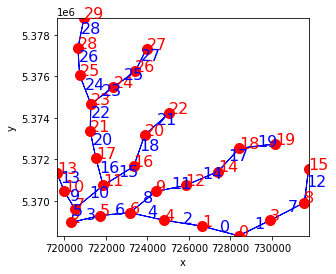

In [16]:
graph.plot_graph(grid, at="node,link")

## 3. Set up elements for running NST


Populate the grid with the relevant topographic and hydrologic information necessary for running NST.

Topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment) are defined separately. Here we assumed the bedrock elevation is 10% lower than surface elevation, channel width is 2 meters and flow depth is 1 meter.

In [50]:
 #set bedrock elevation given the topographic elevation
grid.at_node["bedrock__elevation"] =0.9* grid.at_node["topographic__elevation"].copy()
#set an arbitary channel width
grid.at_link["channel_width"] = 2 * np.ones(grid.number_of_links) # m
#set an arbitrary flow depth
grid.at_link["flow_depth"] = 1 * np.ones(grid.number_of_links) # m

Following figure illustrates influences of natural events such as wildfire and landslide on sediment supply and transport through the river system:

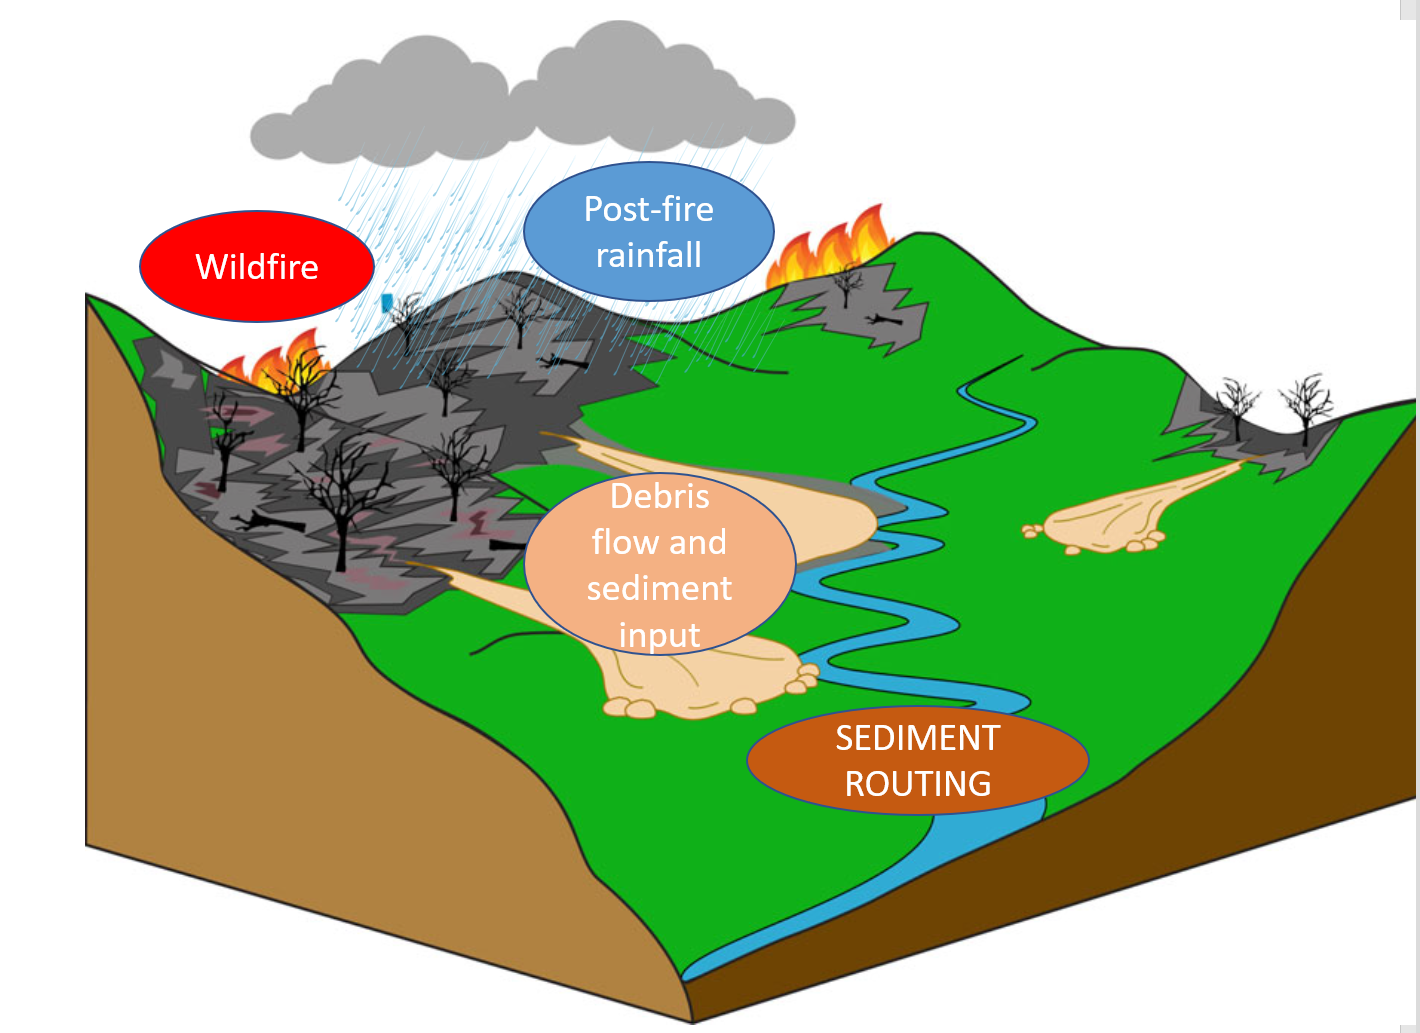

In [17]:
from IPython.display import Image
Image(filename='image.png')

## Create sediment 'parcels' in a DataRecord
We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab [DataRecord](../data_record/DataRecord_tutorial.ipynb).

First, let's create arrays with all of the essential sediment parcel variables.
We want to randomly assign parcels in the channel links. We use a normal (Gaussian) distribution for that.

In [85]:
# Choose mean value of parcels of each link
mean = 100
# Choose standard deviation of the distribution (spread of 'width' of distribution)
sd = 100
# Defining the number of parcels of each link
number_parcels = np.random.normal(mean, sd, size=grid.number_of_links).astype(np.int64)
# We set limit values of the distribution
min_number_parcel = 0
max_number_parcel = 2*mean
number_parcels[number_parcels < min_number_parcel] = min_number_parcel
number_parcels[number_parcels > max_number_parcel] = max_number_parcel

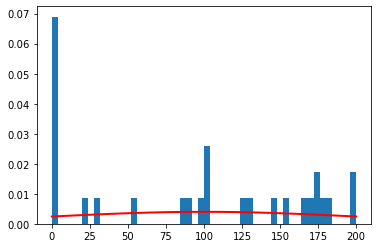

In [86]:
# Check how the distribution of number of sediment parcels look like
count, bins, ignored = plt.hist(number_parcels, 50, density=True)
plt.plot(bins, 1/(sd * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mean)**2 / (2 * sd**2) ),
         linewidth=2, color='r')
plt.show()

In [39]:
# Check how many parcels each links has
print(number_parcels)

[ 76  33 114 136  88  67  33 144 161 120 109  87  95  44  82 147  63  96
  65  96  27 187  64 198 129  23 136 159 156]


In [87]:
# Now we assign the parcels for an element_id, wich is the link on which the parcel begins
element_id = np.repeat(np.arange(grid.number_of_links), number_parcels)
element_id = np.expand_dims(element_id, axis=1)

# Sediment characteristics of each parcel
volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Randomly define the grain size of parcel: Lognormal GSD
medianD = 0.15 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which is a normalized value ranging from 0 to 1) according to a sediment transport formula. 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [88]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. For example:

In [89]:
lithology = ["quartzite"] * np.size(element_id)

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (["item_id", "time"]), and others of which will remain constant through time :

In [90]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "dummy_element" here, which has index value -2.

In [91]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## 4. Run the NetworkSedimentTransporter

With the parcels and grid set up, we can move on to setting up the model.

In [92]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *2 # length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component:

In [93]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

Then initialize the NST:

In [94]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

Now we are ready to run the model forward in time:

In [95]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    print("Model time: ", t/(60*60*24), "days passed")

Model time:  0.0 days passed
Model time:  2.0 days passed
Model time:  4.0 days passed
Model time:  6.0 days passed
Model time:  8.0 days passed
Model time:  10.0 days passed
Model time:  12.0 days passed
Model time:  14.0 days passed
Model time:  16.0 days passed
Model time:  18.0 days passed


## 5. Plot the model results

There are landlab plotting tools specific to the `NetworkSedimentTransporter`. In particular, `plot_network_and_parcels` creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes.  

Here, we demonstrate one example use of `plot_network_and_parcels`. For a thorough tutorial on the plotting tools, see [this notebook](../network_sediment_transporter/network_plotting_examples.ipynb).


We can color links by values that we calculate. For example, if we are curious about the fate of sediment that started out on link 18 after one timestep, we can plot the total volume of sediment that originated on link 18.

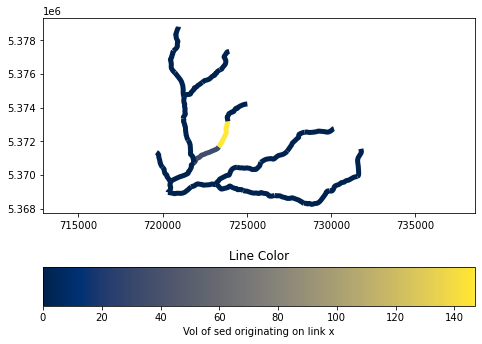

In [96]:
timestep_of_interest = 1
originating_link = 18

#filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(
    parcels.dataset.element_id, dtype=bool
)
parcelfilter[:, timestep_of_interest] = (parcels.dataset.element_id[:,0] == originating_link)

vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

fig = plot_network_and_parcels(
    grid, parcels,
    parcel_time_index=0, 
    link_attribute=vol_orig_link, 
    link_attribute_title = "Vol of sed originating on link x",
    network_linewidth = 5,
    parcel_alpha = 0
)

Another example, if we are curious about the fate of sediment that started out on link 27, we might want to plot the total volume of sediment that originated on link 27 during a later timestep:

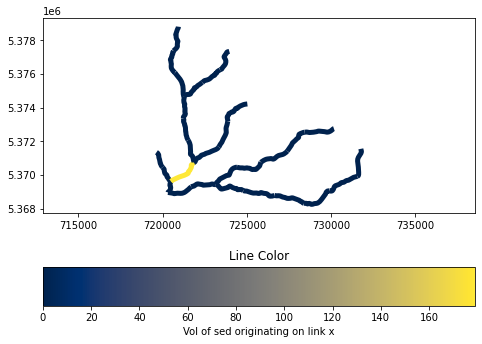

In [97]:
timestep_of_interest = 10
originating_link = 18

#filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(
    parcels.dataset.element_id, dtype=bool
)
parcelfilter[:, timestep_of_interest] = (parcels.dataset.element_id[:,0] == originating_link)

vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

fig = plot_network_and_parcels(
    grid, parcels,
    parcel_time_index=0, 
    link_attribute=vol_orig_link, 
    link_attribute_title = "Vol of sed originating on link x",
    network_linewidth = 5,
    parcel_alpha = 0
)

Here, we demonstrate one example use of plot_network_and_parcels, which creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes. For a thorough tutorial on the plotting tools, see this notebook.

Below, each link (represented as a line) is colored by the total volume of sediment on the link. Each parcel is colored by the parcel grain size.

Note that there parcels were randomly assigned to links, so there are links with no parcels and links with many parcels

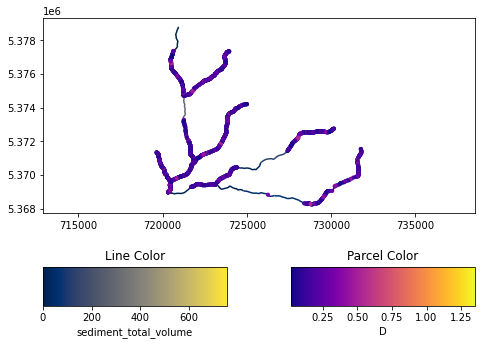

In [98]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)

### Non-network plotting

The results of the NST can be visualized by directly accessing information about the grid, the parcels, and by accessing variables stored after the run of NST.

As a simple example, we can plot the total volume of parcels on the grid through time. As parcels exit the grid, the total volume decreases.

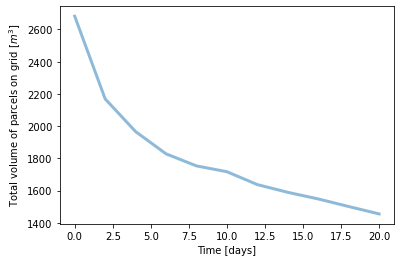

In [99]:
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         np.sum(parcel_vol_on_grid, axis=0),
         '-',
         linewidth=3, 
         alpha=0.5
        )

plt.ylabel('Total volume of parcels on grid $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 

We can also plot individual parcel characteristics. The plot below shows the total transport distance of each parcel through the whole model run as a function of the parcel's grain size (during the final timestep). 

Text(0, 0.5, 'Cumulative parcel travel distance (m)')

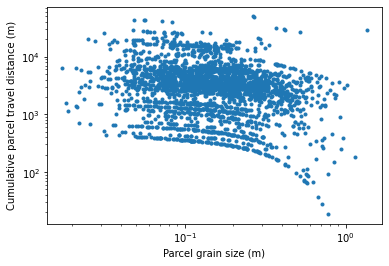

In [100]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance (m)')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate

The plot below is an example of accessing variables associated with the grid (grid.at_link.X, or grid.at_node.X), as well as a variable associated with this instance of NetworkModelGrid (nmg.X):

Text(0, 0.5, 'Mean grain size of active layer (m)')

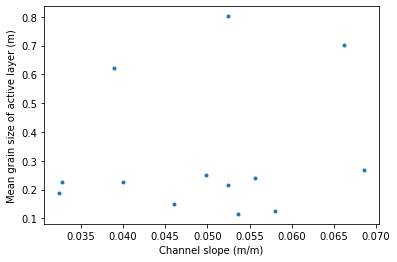

In [101]:
plt.plot(grid.at_link["channel_slope"],
         nst.d_mean_active, 
         '.')
plt.xlabel('Channel slope (m/m)')
plt.ylabel('Mean grain size of active layer (m)')

## Conclusion
We presented a modeling framework linking multiple LandLab components to understand sediment dynamic in stream network resulting from landscape disturbances, such as randome fires, landslides, or landcover changes. In this example we showed how we might connect NST with SPACE, and with a simple stream network model we demonstrated how variable sediment inputs affect sediment transport throughout the stream network. 

Next steps are to complete the coupling of other Landlab components with NST to simulate complex stream network system. The modeling framework provides a foundation for exploring the instantaneous and long-term changes to sediment transport in the stream network. For example, HYLAND may be coupled with NST to examine the impact of landslide on downstream sediment flux. 